<center><h1> AdaBoost pour la prédiction de Séries Temporelles </h1> </center>
<hr>


AdaBoost, abréviation de "Adaptive Boosting", est un algorithme d'apprentissage supervisé qui vise à améliorer la précision des prédictions en combinant plusieurs modèles faibles pour créer un modèle robuste et précis. Il a été introduit par Yoav Freund et Robert Schapire en 1997. Initialement conçu pour la classification, AdaBoost a été adapté pour la régression et la combinaison de prévisions de séries temporelles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## AdaBoost, l'art de l'amplification stratégique

L'idée principale derrière AdaBoost est de créer un "classificateur fort" $f$ en combinant plusieurs "classificateurs faibles" $f_k(x)$ :

$$f(x) = \sum\limits_{k=1}^K \alpha_t f_k(x)$$

Un classificateur faible est un modèle qui n'est pas nécessairement très précis. AdaBoost améliore alors la capacité de prédiction en ajustant itérativement les poids des observations.

Notons $\left\{\left(x_i,y_i\right)\right\}_{1 \leq i \leq q}, x_i \in X, y_i \in Y$ dans l'algorithme.

1. **Initialisation :** Chaque observation de l'ensemble de données reçoit un poids égal au début.
$w_1(i) = \frac{1}{q}$


2. **Itération sur les classificateurs :** (pour $k = 1$ à $K$)
    - **Formation et entrainement d'un classificateur faible :** À chaque étape, un nouveau classificateur faible est formé en se concentrant sur les cas mal classés à l'étape précédente, en donnant différents poids aux instances de données pendant l'entraînement du modèle. On note $y_i = f_k(x_i)$ la prédiction de chaque classifieur faible $f_k$.

    - **Calcul de la fonction de perte (`Loss`):** La fonction de perte attribue à chaque prédiction une erreur relative. Pour une observation $i$ et un classifieur $k$, elle est notée $L_i^k$. On définit ensuite la **perte moyenne pondérée** pour un classifieur $k$ : $$\bar{L_k} = \frac{\sum\limits_{i=1}^{N} w_k(i) L_i^k}{\sum\limits_{i=1}^N w_k(i)}$$

    - **Calcul du critère d'arrêt (`beta`):** Le critère d'arrêt, noté $\beta_k$ permet de mettre à jour les poids de chaque observation en prenant en compte la perte moyenne pondérée du classifieur $k$.

    - **Mise à jour des poids :** Après l'entrainement de chaque classifieur, les poids de chaque observations sont mis à jour de la façon suivante :
    $$w_{k+1}(i) = \frac{w_k(i) * e^{\beta_k  (1 - L_i^k)}}{Z_k}$$
    où $Z_k = \sum\limits_{i=1}^N w_k(i)$ est un facteur de normalisation.

    - **Poids du classifieur faible :** le poids $\beta_k$ est attribué au classifieur faible $k$.

3. **Combinaison des classificateurs :** Les prédictions $f_k(x_i)$ de tous les classificateurs sont combinées pour former la prédiction finale $f(x_i)$. Cette combinaison est une somme pondérée basée sur les poids des classificateurs.


<div style='text-align: center'>
    <img src='img/adaboost.jpeg' width='400'>


AdaBoost est ainsi moins susceptible de surapprentissage, et peut améliorer significativement la précision des modèles de base. Cependant, cet algorithme peut être lent et est sensible aux données aberrantes car il donne plus de poids aux observations difficiles.

## Exploration des variantes clés

AdaBoost a plusieurs variantes qui visent à améliorer la précision du modèle en ajustant certains paramètres. Parmi les 7 principales variantes, on trouve AdaBoost.RT de Shrestha et Solomatine (2006), Modified AdaBoost de Goh et al. (2003), le BCC algorithm de de Souza et al. (2010), et Original Threshold-based Boosting d'Avnimelech & Intrator (1999).

Ces algorithmes se distinguent par six méta-paramètres essentiels, l'objectif étant d'identifier comment ces méta-paramètres affectent la précision d'AdaBoost pour optimiser la performance des modèles à travers différentes combinaisons de paramètres.

### La fonction de perte

Elle contrôle l'erreur relative qui est attribuée à une observation prédite, et donc la mise à jour du poids de cette observation pour l'itération suivante $k+1$. Nous allons étudier ici deux types de fonctions de perte :

- La fonction de perte basée sur l'**erreur relative absolue (ARE)**, qui utilise un seuil pour déterminer si une prédiction est considérée comme bonne ou mauvaise (Shrestha et Solomatine, 2006) :

$$L_i^k = 
\begin{cases} 
1, & \text{si } \text{ARE}_i^k > \phi \\
0, & \text{sinon}
\end{cases}
$$
avec 
$$\text{ARE}_i^k = \displaystyle\left\lvert \frac{f_k(x_i) - y_i}{y_i} \right\rvert$$

- La fonction de perte basée sur l'**erreur absolue en pourcentage (APE)**, qui utilise l'erreur de prédiction maximale pour normaliser l'erreur (AdaBoost.R2) :
$$L_i^k = 
\begin{cases} 
\text{APE}_i^k, & \text{si } f_k(x_i) ≠ y_i \\
0, & \text{si } f_k(x_i) = y_i
\end{cases}
$$
avec
$$\text{APE}_i^k = \frac{\lvert f_k(x_i) - y_i \rvert}{D} \in [0, 1]$$
où $D_k$ est l'erreur de prédiction maximale $$D_k = sup_i (\lvert f_k(x_i) - y_i \rvert)$$ 

Par l'utilisation de métriques de Minkowski-r, il est possible de développer une variété de fonction de perte basée sur les fonctions précédentes. Cela permet d'explorer des fonctions de perte plus complexes, telles que les fonctions exponentielles de plus haut ordre simplement en mettant les erreurs ARE et APE à un plus haut ordre: $(\text{APE}^i, \text{ARE}^i)_{i \in [1, 2, 3]}$ pour les ordres $1$, $2$ et $3$.

<div class="alert alert-warning">
    
**Exercice**:

En utilisant les formules ci-dessus, implémenter les fonctions `loss_are` et `loss_ape` qui permettent de calculer les fonctions de perte basées sur les erreurs respectives ARE et APE. 
</div>

In [72]:
# %load solutions/loss.py

def loss_are(y_test: np.array, y_pred: np.array, phi: float=5e-4, ordre: int=2) -> np.array:
    """
    Calcule la fonction de perte ARE, basée sur l'erreur relative absolue et un seuil.

    Paramètres:
      - y_test (np.array): Le tableau des valeurs réelles.
      - y_pred (np.array): Le tableau des valeurs prédites.
      - phi (float): Le seuil au-delà duquel une erreur est considérée comme significative.
      - ordre (int): L'ordre de la fonction de perte.

    Retourne:
      - np.array: Un tableau contenant les valeurs de la fonction de perte pour chaque prédiction.
    """
    
    return None # A compléter


def loss_ape(y_test: np.array, y_pred: np.array, ordre: int=2) -> np.array:
    """
    Calcule la fonction de perte APE, basée sur l'erreur absolue en pourcentage.
    
    Paramètres:
      - y_test (np.array): Le tableau des valeurs réelles.
      - y_pred (np.array): Le tableau des valeurs prédites.
      - ordre (int): L'ordre de la fonction de perte.

    Retourne:
      - np.array: Un tableau contenant les valeurs de la fonction de perte pour chaque prédiction.
    """
    
    return None # A compléter


### Le critère d'arrêt


La variable $\beta_k$ mesure le degré de confiance que nous avons dans les prédictions produites par le modèle $k$

- **Critère d'arrêt borné** (`bounded`), donné par : 
$$\beta_k = \log(\frac{1 - \bar{L_k}}{\bar{L_k}})$$

Cela nécessite $\bar{L_k} ≤ 0.5$. Dans le cas où $\bar{L_k} > 0.5$, l'algorithme s'arrête.

Cette méthode est souvent utilisée, comme par exemple pour AdaBoost.R2, Thresgold-based Boosting ou encore Modified AdaBoost.

- **Critère d'arrêt non borné** (`non-bounded`), donné par 
$$\beta_k = log(\frac{1}{\bar{L_k^n}})$$
où $n$ est le coefficient de puissance (ordre): $n = 1$ (linéaire), $n = 2$ (carré) ou $n = 3$ (cubique).


<div class="alert alert-warning">
    
**Exercice**:

En utilisant les formules ci-dessus, implémenter les fonctions `beta_bounded` et `beta_unbouded` qui permettent de calculer les critères d'arrêt borné et non borné. 
</div>

In [73]:
# %load solutions/beta.py

def beta_bounded(loss_hat: float) -> float:
    """
    Calcule le coefficient beta pour un critère d'arrêt borné.

    Paramètres :
        - loss_hat (float) : La perte estimée.

    Retourne :
        - Le coefficient beta calculé ou -1 si `loss_hat` > 0.5.
    """
        
    return None # A compléter
    
def beta_unbounded(loss_hat: float, ordre: int = 2) -> float:
    """
    Calcule le coefficient beta pour un critère d'arrêt non borné avec un ordre ajustable.

    Paramètres :
        - loss_hat (float) : La perte estimée.
        - puissance (int, optionnel): Le coefficient de puissance, par défaut à 2.

    Retourne :
        - Le coefficient beta calculé.
    """
    
    return None # A compléter

### Méthode de combinaison

Il existe plusieurs méthodes pour combiner les prévisions des différents modèles. Les plus utilisées sont la médiane pondérée et la moyenne pondérée. Nous proposons ici d'étudier à la fois les moyennes et médianes pondérées et équipondérées.

- **Moyenne pondérée** : 
$$ f(x) = \frac{\sum_{k=1}^K \beta_k f_k(x)}{\sum_{k=1}^K \beta_k}$$

- **Moyenne équipondérée** : 
$$ f(x) = \frac{\sum_{k=1}^K f_k(x)}{K} $$

- **Médiane pondérée** : $f_l(x)$ tel que $\beta_l f_l(x) = \text{mediane} (\beta_k f_k(x))_{k \in [1, K]}$

- **Médiane équipondérée** : médiane des $(f_k(x))_{k \in [1, K]}$

<div class="alert alert-warning">
    
**Exercice**:

En utilisant les formules ci-dessus, implémenter la fonction `combination`, qui, selon la méthode spécifiée, retourne la prédiction résultantes de la combinaison des modèles faibles. Il est conseillé d'implémenter une fonction `weighted_median`, afin de faciliter le calcul de la médiane pondérée.
</div>

In [4]:
# %load solutions/combination.py


def weighted_median(predictions: list, weights: list) -> float:
    """
    Calcule la médiane pondérée d'une liste à l'aide des poids qui y sont appliqués.

    Paramètres :
        - predictions (list) : La liste des prédictions pondérées.
        - weights (list) : La liste des poids associés à chaque prédiction.

    Retourne :
        - L'indice de la médiane.
    """

    return None # A compléter


def combination(learners: list, learners_weight: list, X: np.array, combination_method: str = 'weighted_mean') -> np.array:
    """
    Combine les prédictions de plusieurs apprenants selon une méthode spécifiée, avec ou sans pondération.

    Paramètres :
        - learners (list): Liste des modèles à combiner. 
        - learners_weight (list): Liste des poids associés à chaque modèle. Utilisé uniquement pour les méthodes pondérées.
        - X (np.array): Données d'entrée sur lesquelles les prédictions sont effectuées.
        - combination_method (str, optionnel): Méthode utilisée pour combiner les prédictions.
            Valeurs possibles : 'weighted_mean', 'mean', 'weighted_median', 'median'. Par défaut à 'weighted_mean'.

    Retourne :
        - np.array: La prédiction combinée pour les données d'entrée `X`, calculée selon la méthode spécifiée.
    """
        
    if combination_method=='weighted_mean':
        
        y_pred = None # A compléter
        
    elif combination_method=='mean':
        
        y_pred = None # A compléter
        
    elif combination_method=='weighted_median':
        
        y_pred = None # A compléter
        
    elif combination_method=='median':
        
        y_pred = None # A compléter
        
    else:
        raise ValueError("La méthode de combinaison spécifiée n'est pas valide.")
    
    return y_pred

### Calcul de la perte d'ensemble

Dans le boosting, le critère d'arrêt traditionnel repose sur la performance du dernier modèle ajouté. Toutefois, l'erreur d'entraînement du modèle combiné pourrait atteindre zéro avant ces critères, indiquant un ajustement parfait aux données d'entraînement et suggérant un arrêt de l'entraînement pour éviter une complexité inutile.

Une nouvelle méthode, le **calcul de la perte d'ensemble**, propose d'évaluer la perte à chaque itération en considérant la sortie combinée de tous les modèles jusqu'à l'itération courante $k$, visant à créer un modèle d'ensemble plus simple et généralisable en prévenant le sur-ajustement.

### Taille de la combination

La taille de l'ensemble peut être contrôlée pour optimiser les performances du modèle de boosting, en équilibrant entre la prévention du surajustement et une convergence adéquate avec le processus générant les données.

Il existe principalement deux méthodologies pour déterminer la taille de l'ensemble :

- **L'arrêt Précoce par Validation Croisée :** Cette méthode vise à prévenir le surajustement (`overfitting`). Chaque série temporelle est divisée en trois ensembles de données disjoints : l'entrainement, la validation et le test. Si l'ajout de modèles supplémentaires à la combinaison entraîne une augmentation de l'erreur quadratique moyenne (MSE) sur l'ensemble de validation, l'entraînement s'arrête.

- **L'inclusion d'un nombre prédéfini de modèle (50) dans la combinaison finale :** le compromis ici est qu'en l'absence d'un ensemble de validation pour aider à prévenir le surajustement, cette méthode fournit plus de données pour l'entraînement, ce qui peut permettre un meilleur apprentissage et permettre au modèle de converger avec le processus générant les données sous-jacentes. Dans la pratique, **50 modèles** sont utilisés.

Dans cette étude, nous utiliserons uniquement l'inclusion d'un nombre prédéfini de modèle dans la combinaison finale.

### Modèles utilisés

- **CART pour les arbres de décision**

L'algorithme CART (Classification and Regression Trees) est une méthode statistique utilisée pour construire des arbres de décision. Les divisions sont choisies pour minimiser l'erreur quadratique totale ou la variance au sein de chaque nœud enfant.

- **Réseau MLP**

Le perceptron multicouche (MLP) est un type de réseau de neurones artificiels utilisé notamment pour la régression grâce à sa capacité à apprendre des représentations non-linéaires. Le réseau MLP implémenté est optimisé pour répondre à la problématique des séries temporelles. Cet aspect ne sera pas abordé ici en raison de sa longue durée d'exécution. Pour davantage de détails, consulter l'`ANNEXE 1`.

In [5]:
from sklearn.tree import DecisionTreeRegressor

DecisionTreeRegressor(max_depth=5)

DecisionTreeRegressor(max_depth=5)

### Métrique SMAPE

La métrique **SMAPE** (Symmetric Mean Absolute Percentage Error) est une mesure de précision basée sur les erreurs de prévision. Elle est utilisée pour évaluer l'exactitude des prévisions en traitant de manière équitable les sur-prévisions et les sous-prévisions. Elle prend en compte à la fois l'erreur absolue de la prévision par rapport à la valeur réelle et l'importance relative de cette erreur par rapport à la moyenne de ces deux valeurs, la rendant très efficace dans l'analyse de séries temporelles.


La formule de la SMAPE est la suivante :

$$\text{SMAPE} = \frac{100}{n} \sum\limits_{i=1}^{n} \frac{2 |f(x_i)- y_i|}{|f(x_i)| + |y_i|}$$

où :
- $n$ est le nombre total de points de données,
- $f(x_i)$ est la valeur prédite,
- $y_i$ est la valeur réelle.


<div class="alert alert-warning">
    
**Exercice**:

En utilisant la formule ci-dessus, implémenter la fonction `smape`, qui calcule l'erreur à partir des séries de valeur prédite et réelle.
</div>

In [6]:
# %load solutions/smape.py

def smape(y_pred: np.array, y_true: np.array) -> float:
    """
    Calcule l'erreur SMAPE entre une série de valeur réelle et une série de valeur prédite.

    Paramètres :
        - y_pred (np.array) : Valeurs prédites.
        - y_true (np.array) : Valeurs réelles.

    Retourne :
        - float : La valeur SMAPE entre les valeurs prédites et les valeurs réelles.
        
    """
    
    return None # A compléter

## Implémentation de la classe

Il est maintenant temps de tout rassembler dans une unique classe.

In [7]:

class MyAdaBoostForest:
    def __init__(self, verbose=True, n_steps=50, loss='ape', beta='unbounded', base_model='CART', combination='weighted_mean'):
        self.n_steps = n_steps
        self.sample_weights = None
        self.learners = []
        self.learners_weight = []
        self.verbose = verbose
        
        # Paramètres de l'algorithme
        self.base_model = base_model
        self.loss_method = loss
        self.beta_method = beta
        self.combination_method = combination

    def fit(self, X, y):
        # Initialisation des poids
        self.sample_weights = np.ones(len(y)) / len(y)

        for i in range(self.n_steps):
            
            # Entrainement du classifieur faible en lui passant les paramètres de poids
            if self.base_model == 'CART':
                learner = DecisionTreeRegressor(max_depth=5)
                learner.fit(X, y, sample_weight=self.sample_weights)
            else:
                raise ValueError("Le modèle de base spécifié n'est pas valide.")
            
            self.learners.append(learner)

            # Calcul de la perte d'ensemble : prédiction sur l'ensemble des modèles jusqu'à présent
            # Ajout d'un poids arbitrairement égale à 1 pour inclure la prédiction du modèle courant
            self.learners_weight.append(1)
            y_pred = learner.predict(X)
            
            
            # Calcul de la fonction de perte
            if self.loss_method == 'are':
                loss = loss_are(y, y_pred)
            elif self.loss_method == 'ape':
                loss = loss_ape(y, y_pred)

            # Calcul de la perte moyenne pondérée
            loss_hat = np.sum(self.sample_weights * loss) / (np.sum(self.sample_weights))

            # Arrêt de l'algorithme si la perte est suffisamment faible
            if loss_hat <= 1e-9:
                if self.verbose:
                    print("-- Arret de l'algorithme a l'etape ", i, " car loss_hat = ", loss_hat, " < 1e-9 --")
                break
            
            # Calcul du critère d'arrêt
            if self.beta_method == 'unbounded':
                beta = beta_unbounded(loss_hat)
            else:
                beta = beta_bounded(loss_hat)
                if beta == -1:
                    if i == 0:
                        beta = beta_unbounded(loss_hat)
                        if self.verbose:
                            print("-- Utilisation de beta unbounded car loss_hat = ", loss_hat," > 0.5 à l'étape 0 --")
                    else:
                        if self.verbose:
                            print("-- Arret de l'algorithme a l'etape ", i, " car loss_hat = ", loss_hat," > 0.5 --")
                        self.learners.pop()
                        self.learners_weight.pop()      # Suppression du poids précédemment ajouté
                        break

            # Mise à jour des poids
            for j in range(len(y)):                
                self.sample_weights[j] = self.sample_weights[j] * np.exp(beta * (1 - loss[j]))
                
            # Normalisation des poids
            self.sample_weights /= sum(self.sample_weights)
            
            # Stockage du poids du classifieur courant
            self.learners_weight.pop()      # Suppression du poids précédemment ajouté
            self.learners_weight.append(beta)

    def predict_model(self, X):
        # Prédiction selon la méthode de combination spécifiée
        y_pred = combination(self.learners, self.learners_weight, X, self.combination_method)
        return y_pred
            
    def compute_error(self, X, y):
        # Calcul de l'erreur SMAPE
        y_pred = self.predict_model(X)
        error = smape(y_pred, y)
        
        return error
        


## La prédiction de séries temporelles

Une série temporelle est une séquence de points de données mesurés à des intervalles de temps successifs. Elle peut être considérée comme une suite de valeurs représentant l'évolution d'une certaine quantité au fil du temps. Les séries temporelles sont caractérisées par leur fréquence et peuvent présenter des tendances, des saisons, et d'autres structures cycliques.

Nous allons évaluer ici diverses méthodes de boosting sur un ensemble de données comprenant 111 séries chronologiques de ventes industrielles provenant du concours NN3, reconnu comme une référence fiable et représentative pour les méthodes d'intelligence computationnelle.

### Exploration du dataset NN3

Cet ensemble se compose de 100 séries chronologiques mensuelles longues et courtes, avec un équilibre entre tendances saisonnières et non saisonnières. La durée des séries varie entre 68 et 144 mois. Onze séries supplémentaires présentent des complexités spécifiques. Cette conception équilibrée permet d'analyser la précision des algorithmes d'amplification dans des conditions industrielles typiques, en évaluant leurs performances sur des séries variées, y compris celles présentant des modèles de données complexes.

In [38]:
df = pd.read_csv('NN3_dataset.csv', sep=',',header=0)

# Exploration des données
print('Taille du dataframe :', df.shape)
print("Nombre d\'observations d'entrainement :", len([col for col in df.columns if col[:3] == 'FIT']))
print('Nombre d\'observations à prédire :', len([col for col in df.columns if col[:4] == 'PRED']))
df.head(1)

Taille du dataframe : (111, 150)
Nombre d'observations d'entrainement : 126
Nombre d'observations à prédire : 18


,NN3 Time Series #ID,Original M3 Time Series,Start Year,Start Month,Months per Year,Dataset,FIT_126,FIT_125,FIT_124,FIT_123,...,PRED_8,PRED_9,PRED_10,PRED_11,PRED_12,PRED_13,PRED_14,PRED_15,PRED_16,PRED_17
0,NN3-001,N1484MB083,1990,1,12,complete,NaN,NaN,NaN,NaN,...,6770,6320,5960,6190,5250,5910,6430,5950,5060,5400.0


### Gestion des séries temporelles

Nous implémentons ci-dessous une fonction destinée à simplifier la manipulation d'une série temporelle à partir de son identifiant, en plus d'une fonction permettant l'affichage des séries sélectionnées accompagnées des données de test ou de prédiction.

In [30]:

def get_ts(id: str):
    """
    Extrait une série temporelle spécifique par son identifiant dans un DataFrame pandas.
    
    Paramètres:
        - id (str): Identifiant unique de la série temporelle à extraire.
    
    Retourne:
        - np.array: La série temporelle nettoyée et convertie en tableau numpy.
    """
    
    to_rm = ['NN3 Time Series #ID', 'Original M3 Time Series', 'Start Year',
             'Start Month', 'Months per Year', 'Dataset']
    
    ts = df[df['NN3 Time Series #ID'] == id]
    
    for col in to_rm:
        del ts[col]
    ts = np.array(ts.dropna(axis=1))[0]
    
    return ts

def plot_ids(ids: list, test: bool=False, preds: list=None):
    """
    Affiche les séries temporelles pour une liste d'identifiants spécifiés.

    Paramètres:
        - ids (list): Liste des identifiants des séries temporelles à tracer.
        - test (bool): Si True, trace les 18 derniers points test de la série en vert.
        - preds (list ou bool): Si une liste est fournie, trace les prédictions en rouge.
    
    Retourne:
        - None. Affiche un graphique des séries temporelles.
    """
    
    n = len(ids)
    plt.figure("Time series from NN3", figsize=(20, 3*(n+2)//3))
    
    for count, id in enumerate(ids):
        ts = get_ts(id)
        t = list(range(len(ts)))
        
        plt.subplot((n+2)//3, 3, count+1)
        plt.title(id)
        plt.plot(ts[:-17], 'b', label='Données d\'entrainement')
        
        if test:
            plt.plot(t[-18:], ts[-18:], 'g', label='Données de test')
        
        if preds:
            plt.plot(t[-18:], preds[count], 'r', label='Prédictions')
    
    legend=['Données d\'entrainement']
    if test:
        legend.append('Données de test')
    if preds:
        legend.append('Prédictions')
    plt.figlegend(legend, loc='lower center', ncol=3)
    
    return None


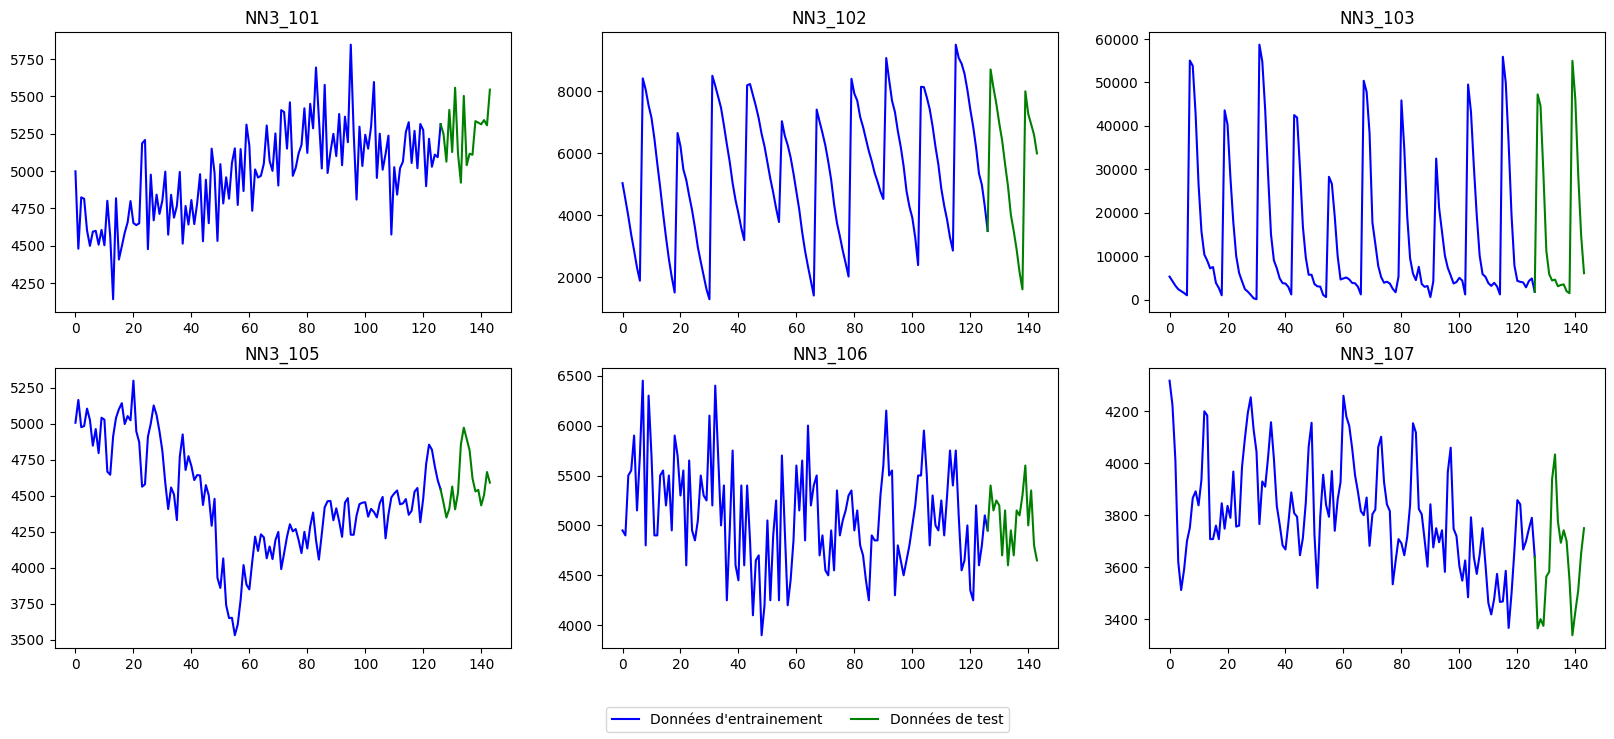

In [31]:
ids = ['NN3_101','NN3_102','NN3_103','NN3_105','NN3_106','NN3_107']

plot_ids(ids, test=True)

Nous observons ici quelques séries temporelles. Chacune présente des motifs distincts, ce qui complexifie la prédiction et rend ainsi plus robuste l'évaluation de l'algorithme sur cet ensemble de données.

### Prédiction de séries temporelles

La prédiction de séries temporelles consiste à utiliser des données historiques pour prévoir des valeurs futures dans le temps. Il faut donc les transformer en un format adapté à l'apprentissage supervisé, ce qui implique de créer des paires d'entrées et de sorties à partir des données historiques.

Cette transformation se fait couramment à l'aide de **fenêtres glissantes**. Elles permettent de structurer des données temporelles séquentielles de manière à ce que les modèles puissent apprendre à prédire une valeur future à partir d'un ensemble de valeurs passées.


<div class="alert alert-warning">
    
**Exercice**:

Implémenter une fonction qui, à partir d'une série temporelle continue, crée un ensemble de paires d'entrée-sortie où chaque entrée est une séquence de données consécutives et la sortie est la valeur suivante dans la série. Ces paires peuvent ensuite être utilisées pour entraîner un modèle de prédiction.

</div>

In [11]:
# %load solutions/ts_to_windows.py

def ts_to_windows(ts: np.array, size_window: int = 18):
    """
    Transforme une série temporelle en ensembles de données pour l'apprentissage supervisé 
    en utilisant la méthode des fenêtres glissantes.

    Paramètres:
        - ts (np.array): Le tableau contenant les valeurs de la série temporelle. 
        - size_window (int, optionnel): La taille de la fenêtre glissante, ie le nombre 
                                        de valeurs consécutives de la série temporelle à utiliser 
                                        comme une seule entrée.
                                        La valeur par défaut est 18 car 18 observations sont à prédire

    Retourne:
        - Tuple de deux éléments:
            - X (np.array) : Un tableau numpy de taille `(nb_windows, size_window)`, où chaque ligne 
                    représente une fenêtre de `size_window` valeurs consécutives de la série temporelle.
            - y (np.array) : Un tableau numpy de forme `(nb_windows,)`, contenant la valeur suivant 
                    chaque fenêtre dans `X`, servant de sortie correspondante.

    """

    return None # A compléter

<div class="alert alert-warning">
    
**Exercice**:

Implémenter une fonction qui, à partir d'un identifiant de série temporelle et des paramètres choisis pour le modèle, renvoie les prédictions pour cette série et l'erreur SMAPE entre les prédictions et les valeurs réelles de l'ensemble de test.

</div>

In [12]:
#%load solutions/evaluate_id.py

def evaluate_id(id:str,verbose: bool=True, combination_method: str ='weighted_mean', base_model: str='CART', loss_method: str='ape', beta_method: str='unbounded'):
    """
    Applique et évalue le modèle de prévision pour une série temporelle et une combinaison de méthodes donnés.
    
    Paramètres :
        - id (str) : L'identifiant des données de la série temporelle à prévoir.
        - verbose (bool, optionnel) : Si True, le modèle affichera des messages de progression pendant l'entraînement.
        - combination_method (str, optionnel) : La méthode utilisée pour combiner les prédictions des apprenants de base dans le modèle d'ensemble.
        - base_model (str, optionnel) : Le type de modèle de base à utiliser dans l'ensemble.
        - loss_method (str, optionnel) : La fonction de perte utilisée par le modèle.
        - beta_method (str, optionnel) : La méthode utilisée pour calculer les poids (bêtas) dans l'algorithme AdaBoost.
        
    Retourne :
        - Tuple de deux éléments :
            - pred (np.array) : Les prédictions pour l'ensemble de test.
            - smape (float) : L'erreur SMAPE entre les prédictions et les valeurs réelles de l'ensemble de test.
    """

    return None # A compléter

-- Erreurs SMAPE --


NN3_101  :  2.3097587537864612
NN3_102  :  12.8470744179321
NN3_103  :  37.17592341629991
NN3_105  :  1.7410524249406687
NN3_106  :  5.734729096199328
NN3_107  :  4.062686882522415


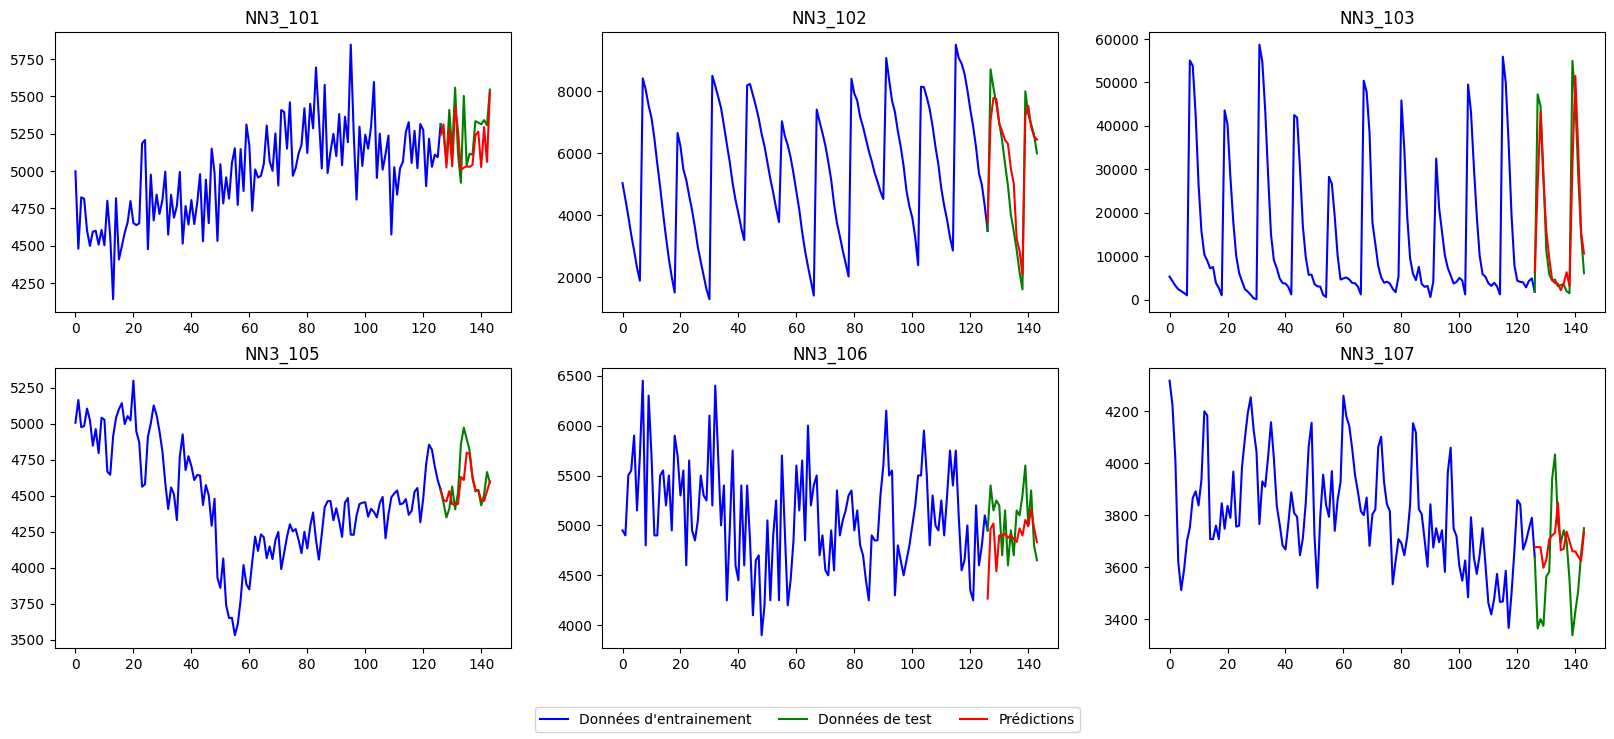

In [34]:
ids = ['NN3_101','NN3_102','NN3_103','NN3_105','NN3_106','NN3_107']

print("-- Erreurs SMAPE --")
preds= []
for id in ids:
    
    pred, error= evaluate_id(id, verbose=True)    
    print(id, " : ", error)

    preds.append(pred)
    
plot_ids(ids,test=True, preds=preds)
    

# Comparaison des méthodes

Ici, nous évaluons les erreurs SMAPE lors de l'application de chaque combinaison sur toutes les séries temporelles à disposition. Pour pouvoir manipuler et accéder à tous les calculs, nous stockons les résultats dans un DataFrame Pandas.

In [14]:
loss_methods = ['ape', 'are']
beta_methods = ['bounded', 'unbounded']
combination_methods = ['weighted_mean', 'mean', 'weighted_median', 'median']
base_models = ['CART']

ids = df['NN3 Time Series #ID'].unique()

results = pd.DataFrame(columns=['id', 'loss_method', 'beta_method', 'combination_method', 'base_model', 'error', 'prediction'])

for id in ids:
    for loss_method in loss_methods:
        for beta_method in beta_methods:
            for combination_method in combination_methods:
                for base_model in base_models:
                    pred, error = evaluate_id(id, verbose=False, combination_method=combination_method, base_model=base_model, loss_method=loss_method, beta_method=beta_method)

                    results.loc[results.shape[0]+1] = {'id': id, 'loss_method': loss_method, 'beta_method': beta_method, 'combination_method': combination_method, 'base_model': base_model, 'error': error, 'prediction': pred}

In [35]:
print(results.shape)
results.head()

(1776, 7)


,id,loss_method,beta_method,combination_method,base_model,error,prediction
1,NN3-001,ape,bounded,weighted_mean,CART,7.770519,"[6076.3050983551675, 5847.874776100506, 6069.6..."
2,NN3-001,ape,bounded,mean,CART,8.177716,"[6050.571798433277, 5894.096430399193, 6064.21..."
3,NN3-001,ape,bounded,weighted_median,CART,10.758088,"[5810.0, 5643.240639330774, 6509.0774837983145..."
4,NN3-001,ape,bounded,median,CART,8.309780,"[5822.594927336456, 5735.66479904512, 6224.631..."
5,NN3-001,ape,unbounded,weighted_mean,CART,7.598205,"[5995.648872342737, 6015.289331406247, 6452.06..."


In [37]:
# Erreur moyenne par méthode sur l'ensemble des séries temporelles
results.groupby(['loss_method', 'beta_method', 'combination_method', 'base_model'])['error'].mean().sort_values()

loss_method  beta_method  combination_method  base_model
ape          unbounded    mean                CART          16.715038
                          weighted_mean       CART          16.750143
             bounded      mean                CART          16.778621
                          weighted_mean       CART          17.028835
             unbounded    median              CART          17.566102
are          bounded      mean                CART          17.704170
ape          bounded      median              CART          17.876202
are          bounded      median              CART          18.147607
                          weighted_mean       CART          18.393786
             unbounded    mean                CART          18.405068
                          median              CART          18.531241
                          weighted_mean       CART          18.733480
ape          bounded      weighted_median     CART          18.979268
are          bounded      weighte

Ce tableau présente les erreurs moyennes SMAPE pour chaque variante sur l'ensemble des séries temporelles. Les combinaisons de méthodes les plus performantes sont celles avec les erreurs moyennes les plus faibles. D'après le résultat ci-dessus, il semble que les configurations avec la perte APE et le calcul de beta non borné associé à une combinaison liée à la moyenne tendent à avoir des errurs plus faibles, indiquant potentiellement une meilleure précision du modèle dans ces configurations. 

Globalement, nous relevons que :
- la méthode de perte APE semble plus performante que la méthode de perte ARE.
- le critère d'arrêt non borné est plus performant que le critère d'arrêt borné.
- la moyenne pondérée ou non est bien meilleure que la médiane pondérée dans notre implémentation.

-- Erreurs SMAPE --
NN3-093  :  77.31830974656155
NN3-025  :  56.783839220033116
NN3-096  :  53.73653099491558
NN3-026  :  47.79830799163961
NN3-081  :  44.43350950234248
NN3-046  :  42.50726200804281
NN3-082  :  41.81588266172901
NN3-062  :  40.75516002206582
NN3-044  :  38.55748723529815
NN3-019  :  38.34148132890194
NN3-021  :  37.44484802069793
NN3-047  :  36.90915078603402
NN3-029  :  35.79349242922447
NN3-043  :  33.29621915818018
NN3_110  :  32.92692220210302
NN3-049  :  32.67818540802446
NN3-031  :  32.20770976484788
NN3-045  :  31.768081010433686
NN3_103  :  30.033526212339957
NN3-098  :  27.619792338906603


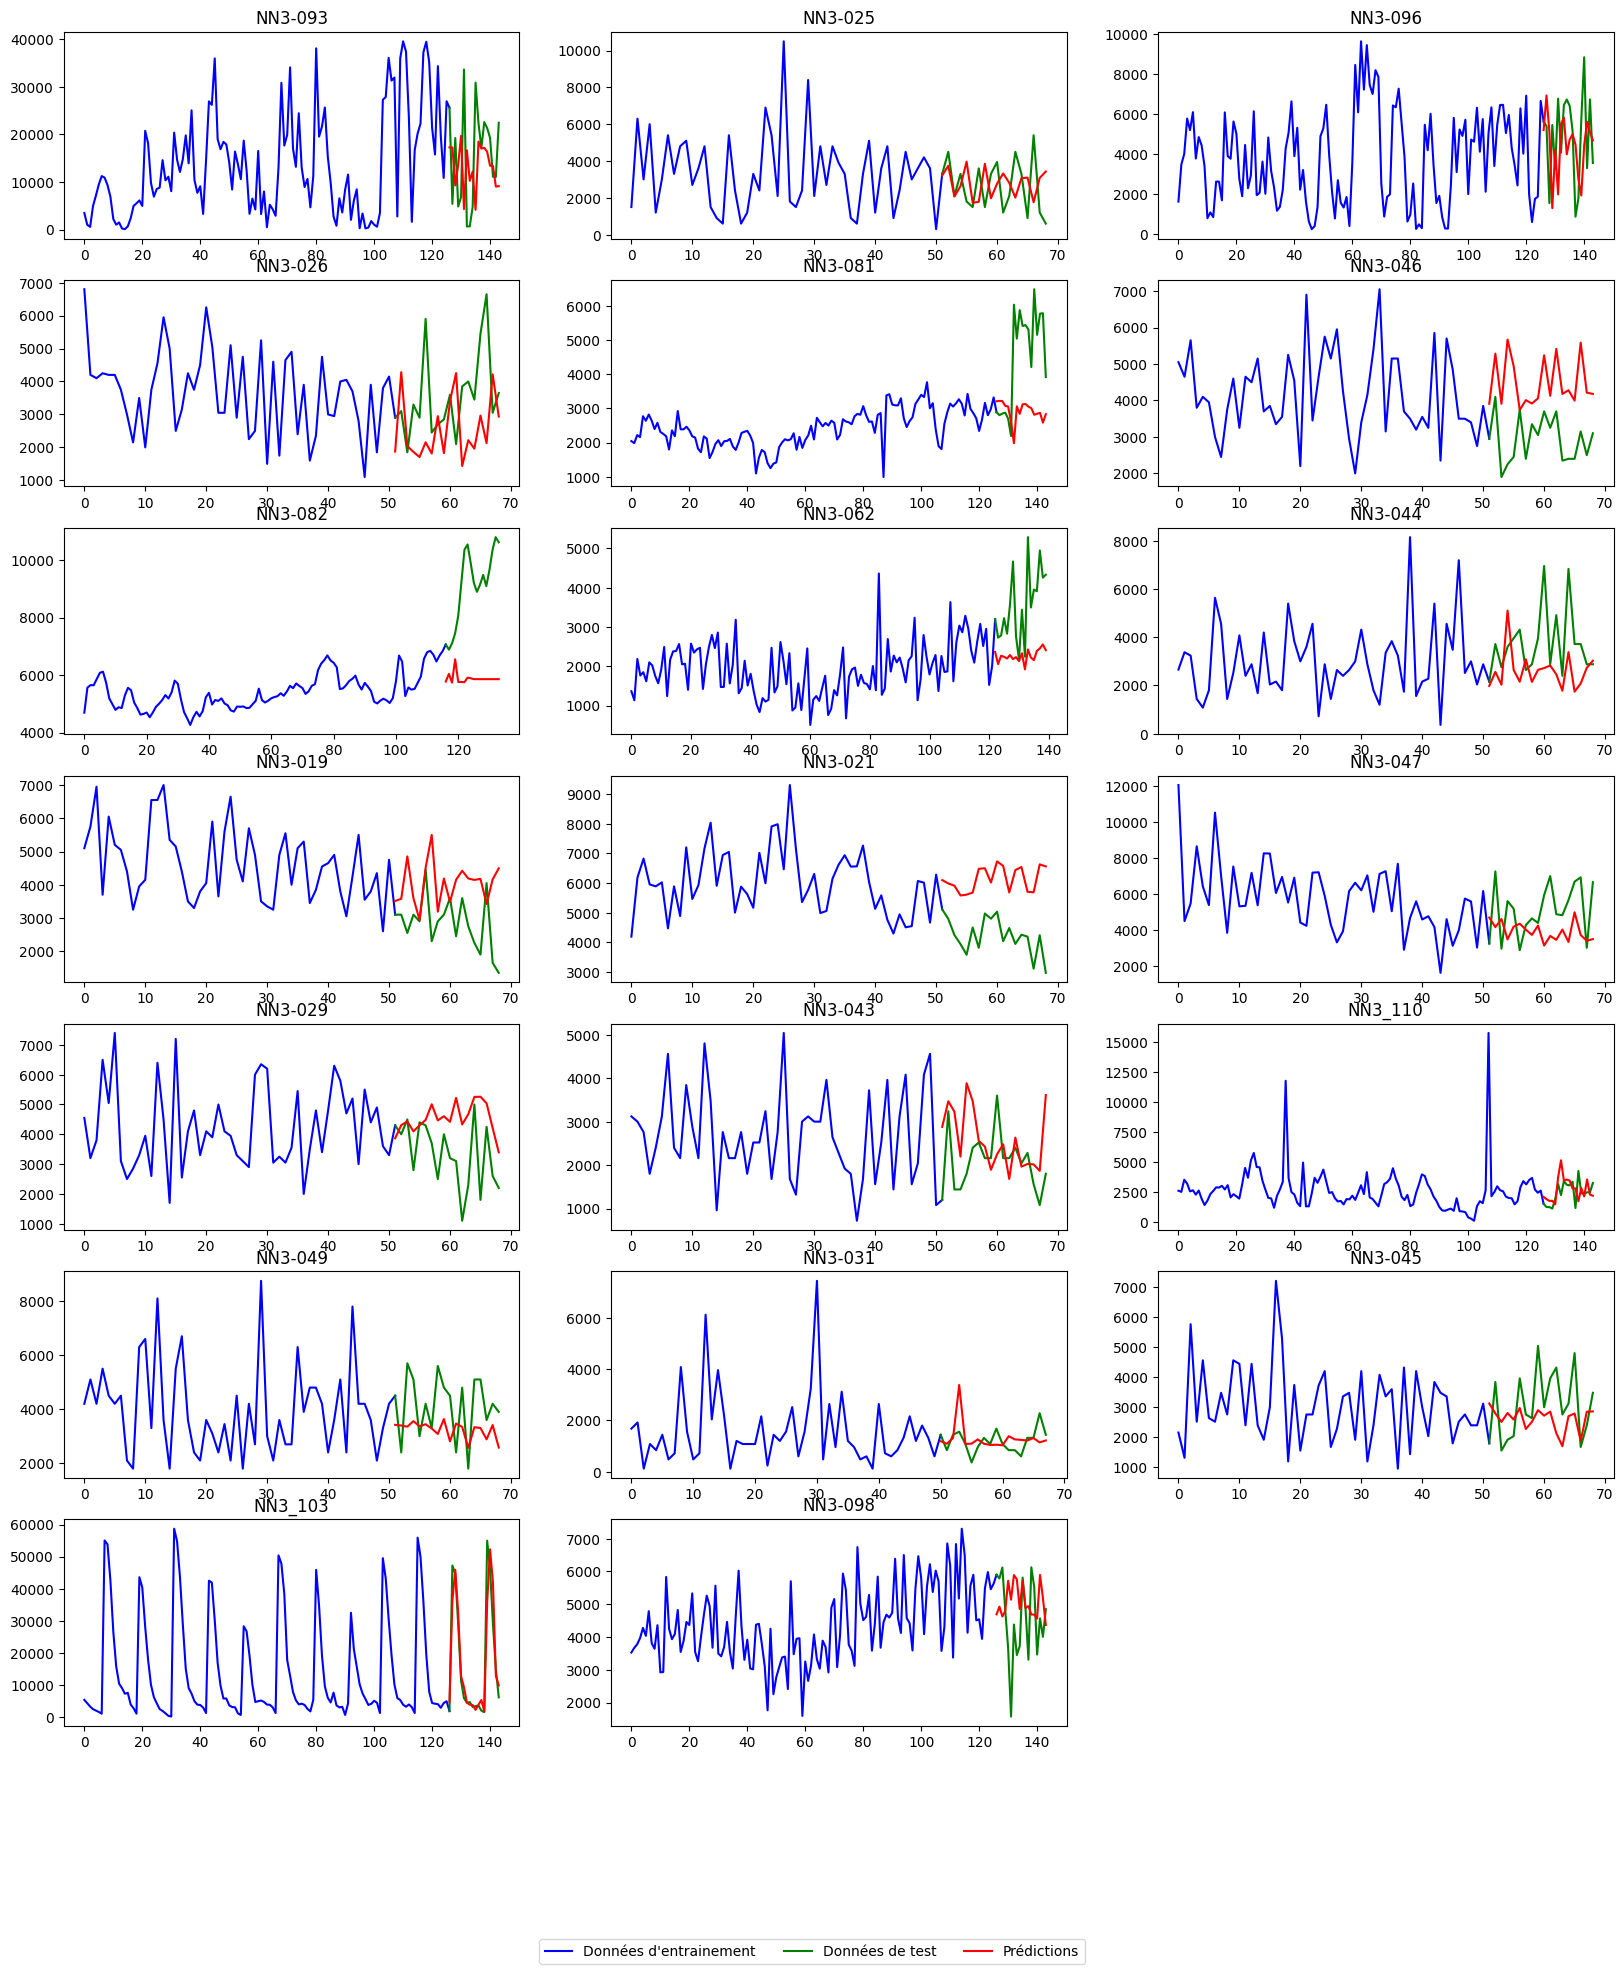

In [70]:
worse_values = results[(results['loss_method']=='ape') & 
              (results['beta_method']=='unbounded') & 
              (results['combination_method']=='weighted_mean') & 
              (results['base_model']=='CART')].groupby(['id'])['error'].mean().sort_values(ascending=False)[:20]

print("-- Erreurs SMAPE --")
preds= []
for id, error in worse_values.items():
    #error = results[results['id']==id]['error'].mean()
    print(id, " : ", error)
    pred = results[(results['id']==id) & 
                   (results['loss_method']=='ape') & 
                   (results['beta_method']=='unbounded') & 
                   (results['combination_method']=='weighted_mean') & 
                   (results['base_model']=='CART')]['prediction'].values[0]

    preds.append(pred)
    
plot_ids(worse_values.index.tolist(),test=True, preds=preds)

En étudiant les séries possédant les plus grandes erreurs SMAPE, et donc sur lesquelles l'algorithme est moins performant, nous remarquons que beaucoup de ces séries présentent des patterns complexes qui n'ont jamais été vu dans l'historique. En effet, les séries NN3-081 et NN3-082 présentent des valeurs plus élevées soudainement qui n'ont pas pu être prédites. D'autres, comme les NN3-098 ou NN3-046 présentent des changements de variations. 

Enfin, dans certains cas l'erreur SMAPE est grande à cause de l'ordre de grandeur des valeurs prises par la série, notamment pour les séries NN3-093 et NN3-096. Ce problème pourra être pallier grâce à une normalisation des données au préalable, qui n'a pas été faite dans cette étude.

## Étude de D.K. Barrow et S.F. Crone

L'étude de D.K. Barrow et S.F. Crone compare les 96 variantes de boosting créées à partir de toutes les combinaisons possibles des méta-paramètres précédemment vus. 

Ils ont notamment fait une étude ANOVA multifactorielle sur l'impact de différents méta-paramètres sur la précision des prévisions de séries temporelles. Les types de séries temporelles sont décomposés selon leur complexité: 
- SS : courte et saisonnière
- SNS : courte et non saisonnière
- LS : longue et saisonnière
- LNS : longye et non saisonnière
- COMPLEX : avec des particularités complexes


<div style='text-align: center'>
    <img src='img/significance_metaparameter.png'>



Les résultats révèlent que certains méta-paramètres, comme le critère d'arrêt ou le type de la fonction de perte, sont très significatifs pour presque tous les types de séries temporelles, tandis que d'autres ne le sont pas dans certains cas (comme SS et ALL pour la fonction de perte).

Dans l'ensemble, nous constatons que tous les méta-paramètres sont significatifs dans les cas les plus complexes. Cela signifie que, pour les séries temporelles complexes, il est crucial de choisir soigneusement les méta-paramètres lors de la conception du modèle afin d'obtenir les prévisions les plus précises possibles. Plus de facteurs s’avèrent insigniﬁants pour les séries chronologiques saisonnières

<div style='text-align: center'>
    <img src='img/results_smape.png'>

Après avoir identifié l’importance des principaux effets, le tableau ci-dessus résume les erreurs SMAPE qu'ils ont obtenues pour tous les métaparamètres, moyennées sur toutes les séries temporelles.

Les résultats montrent que l’erreur de test globale la plus faible est obtenue en utilisant un critère d’arrêt non borné, avec une taille de combinaison fixe et une perte calculée par modèle avec une fonction de perte basée sur un seuil avec un modèle de base MLP (SMAPE de 16,36%). La même combinaison de métaparamètres, à l’exception d’une fonction de perte non basée sur le seuil, est classée deuxième (avec un SMAPE de 16,39%).

Dans l'ensemble :
- le MLP est plus performant que le CART
- le critère d'arrêt non borné est meilleur que le critère d'arrêt borné
- l'utilisation d'un nombre fixe de modèle est meilleur que l'étude de la cross-validation
- le calcul de la perte d'ensemble donne de moins bonne performance que celle de la perte calculée sur le dernier modèle
- la fonction de perte sans seuil (APE) est plus performante que celle avec seuil, sauf dans le cas d'un MLP avec un critère d'arrêt non borné.

Cela est cohérent avec les résultats que nous obtenons, puisque dans notre étude - moins précise que celle de D.K. Barrow et S.F. Crone - nous observons également que la fonction de perte sans seuil (APE) et le critère d'arrêt non borné ont de meilleurs performances que leurs alternatives.

## Conclusion

Dans cette étude, nous avons évaluer les performances de différentes variantes de AdaBoost pour la prévision de séries temporelles industrielles. Les résultats d'une analyse ANOVA multifactorielle après décomposition du boosting en métaparamètres indiquent que le choix de ces méta-paramètres a statistiquement un impact significatif sur la précision du modèle.

Les résultats expérimentaux obtenus par J.K. Barrow et ... montrent qu'une sélection appropriée des méta-paramètres conduit à une précision de prévision améliorée, et permet de dériver une variante de Boosting avec la meilleure combinaison, appelé **AdaBoost.BC**. Cette variante surpasse toutes les autres variantes de Boosting développées pour la prédiction de séries temporelles à ce jour.

Il reste bien sûr diverses extensions de cet algorithme à étudier, notamment via l'amélioration des méta-paramètres. Il est par exemple possible de baser la fonction de perte sur l'erreur SMAPE, ou tout simplement de combiner différents modèles de base.
